In [1]:
import lib.db_connector
import pandas as pd
import numpy as np
from scipy import stats
db = lib.db_connector.DbConnector(db_name = 'speakql_study', verbose = False)

Initializing DbConnector class for a mysql  connection to speakql_study
Attempting to connect to speakql_study
DBCONNECTOR: Connected to 8.0.31-0ubuntu0.22.04.1


#### Get all correct attempt submissions from study participants

In [2]:
query = open("./queries/get_all_correct_queries.sql").read()
correct_answers = db.do_single_select_query_into_dataframe(query)

In [3]:
# Copy the pull from the DB so we can "cache" it locally in case we mess it up below
backup = correct_answers

In [4]:
correct_answers = correct_answers.where(correct_answers.ispractice == 0).dropna(how = 'all')
correct_answers['step_abs'] = correct_answers.apply(
    lambda row:  row.step_speakql - 6 if row.step_speakql < row.step_sql else row.step_sql - 6,
    axis = 1
).astype('int')
print(correct_answers.columns)
correct_answers

Index(['idparticipant', 'idsession', 'idattemptsubmission', 'idquery',
       'tt_speakql', 'rt_speakql', 'pt_speakql', 'fpt_speakql', 'tpt_speakql',
       'tt_all_speakql', 'step_speakql', 'attemptnum_speakql',
       'correct_speakql', 'tt_sql', 'rt_sql', 'pt_sql', 'fpt_sql', 'tpt_sql',
       'tt_all_sql', 'step_sql', 'attemptnum_sql', 'correct_sql', 'tt_diff',
       'tt_perc_diff', 'fpt_diff', 'fpt_perc_diff', 'tpt_diff',
       'tpt_perc_diff', 'rt_diff', 'rt_perc_diff', 'attemptnum_diff',
       'idsequence', 'speakql_first', 'ispractice', 'complexity', 'normalized',
       'is_complex', 'num_mods', 'num_joins', 'num_funcs', 'num_proj',
       'num_tables', 'num_selections', 'synonyms_possible', 'used_synonyms',
       'expression_ordering_possible', 'used_expression_ordering',
       'mod_ordering_possible', 'used_mod_ordering',
       'natural_functions_possible', 'used_natural_functions',
       'unbundling_possible', 'used_unbundling', 'participant_experience',
       'part

,idparticipant,idsession,idattemptsubmission,idquery,tt_speakql,rt_speakql,pt_speakql,fpt_speakql,tpt_speakql,tt_all_speakql,...,used_expression_ordering,mod_ordering_possible,used_mod_ordering,natural_functions_possible,used_natural_functions,unbundling_possible,used_unbundling,participant_experience,participant_self_rating,step_abs
19,14.0,55.0,867.0,2.0,24.0,7.0,17.0,17.0,17,24,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,Graduate student,3.0,1
20,16.0,57.0,970.0,2.0,47.0,8.0,39.0,39.0,39,47,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,None,NaN,1
21,17.0,59.0,1013.0,2.0,22.0,11.0,11.0,11.0,11,22,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,None,NaN,1
22,20.0,63.0,1137.0,2.0,9.0,8.0,1.0,19.0,20,39,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,None,NaN,1
23,11.0,52.0,764.0,2.0,29.0,9.0,19.0,19.0,19,29,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,Undergraduate student,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,22.0,65.0,1229.0,17.0,174.0,104.0,70.0,70.0,70,174,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,None,NaN,12
310,21.0,64.0,1175.0,17.0,634.0,72.0,562.0,562.0,562,634,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,None,NaN,12
311,29.0,66.0,1252.0,17.0,72.0,69.0,3.0,204.0,207,338,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,None,NaN,12
312,12.0,53.0,755.0,17.0,80.0,61.0,19.0,19.0,19,80,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Senior professional,5.0,12


In [5]:
correct_answers.to_excel('./correct_answers_diffs.xlsx')

#### Transformations

In [6]:
#Convert decimals to floats for perc diff cols:
colnames = ['tt_perc_diff', 'fpt_perc_diff', 'tpt_perc_diff', 'rt_perc_diff']
for col in colnames:
    correct_answers[col] = correct_answers[col].astype('float')

#### Use Pandas to generate some calculated fields

In [7]:
correct_answers['second_half'] = correct_answers.apply(
    lambda row: 1 if int(row.idquery) >= 11 else 0,
    axis = 1
)

correct_answers[['idquery','step_speakql', 'speakql_first', 'second_half']]

,idquery,step_speakql,speakql_first,second_half
19,2.0,19.0,0.0,0
20,2.0,19.0,0.0,0
21,2.0,19.0,0.0,0
22,2.0,19.0,0.0,0
23,2.0,7.0,1.0,0
...,...,...,...,...
309,17.0,30.0,0.0,1
310,17.0,18.0,1.0,1
311,17.0,18.0,1.0,1
312,17.0,30.0,0.0,1


**Average Planning Time Percent Difference (positive indicates SpeakQL higher)**

Calculation is (SpeakQL time - SQL Time) / ((SpeakQL time + SQL Time) / 2)

In [8]:
correct_answers.columns

Index(['idparticipant', 'idsession', 'idattemptsubmission', 'idquery',
       'tt_speakql', 'rt_speakql', 'pt_speakql', 'fpt_speakql', 'tpt_speakql',
       'tt_all_speakql', 'step_speakql', 'attemptnum_speakql',
       'correct_speakql', 'tt_sql', 'rt_sql', 'pt_sql', 'fpt_sql', 'tpt_sql',
       'tt_all_sql', 'step_sql', 'attemptnum_sql', 'correct_sql', 'tt_diff',
       'tt_perc_diff', 'fpt_diff', 'fpt_perc_diff', 'tpt_diff',
       'tpt_perc_diff', 'rt_diff', 'rt_perc_diff', 'attemptnum_diff',
       'idsequence', 'speakql_first', 'ispractice', 'complexity', 'normalized',
       'is_complex', 'num_mods', 'num_joins', 'num_funcs', 'num_proj',
       'num_tables', 'num_selections', 'synonyms_possible', 'used_synonyms',
       'expression_ordering_possible', 'used_expression_ordering',
       'mod_ordering_possible', 'used_mod_ordering',
       'natural_functions_possible', 'used_natural_functions',
       'unbundling_possible', 'used_unbundling', 'participant_experience',
       'part

<AxesSubplot:xlabel='value', ylabel='variable'>

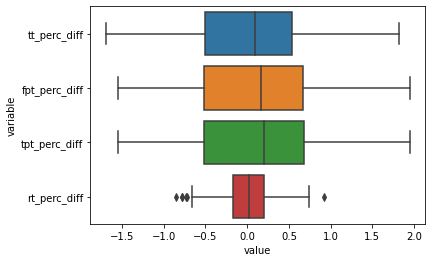

In [11]:
dep_vars = ['tt_perc_diff', 'fpt_perc_diff', 'tpt_perc_diff', 'rt_perc_diff']
import seaborn as sns
sns.boxplot(x='value', y='variable', data = correct_answers[dep_vars].melt())


### Looking for learning effect
The plot and GLM below is looking for learning effect (i.e. participants may get better at speakql compared to their sql performance as they progress through the event).

**Pair Grid interpretation:** Looking at the right-most column, we can compare the performance of the dependent variables (y axis) to the query number (query numbers are in order of appearance in the experiment). I added is_complex as a hue to tease out any colinearity between query number and complexity, because in the experiment queries become progressively more complex.

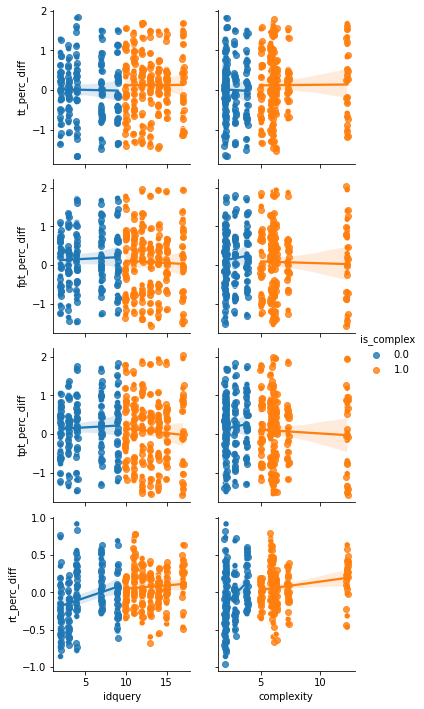

In [12]:
x_vars = ['idquery', 'complexity']

g = sns.PairGrid(
    correct_answers,
    x_vars = x_vars,
    y_vars = dep_vars,
    hue = 'is_complex'
)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.map_offdiag(sns.regplot, x_jitter = 0.1, y_jitter = 0.1, marker = 'o')
g.add_legend()

In [13]:
for var in dep_vars:
    x = correct_answers[[
        'second_half'
    ]]
    x = sm.add_constant(x)
    y = (correct_answers[var])
    model = sm.GLM(y, x).fit()
    predictions = model.predict(x)
    print_model = model.summary()
    print(print_model)

NameError: name 'sm' is not defined

### Visualizing query attributes and percent difference dependent vars

In [14]:
type(correct_answers.tt_perc_diff.iloc[0])

numpy.float64

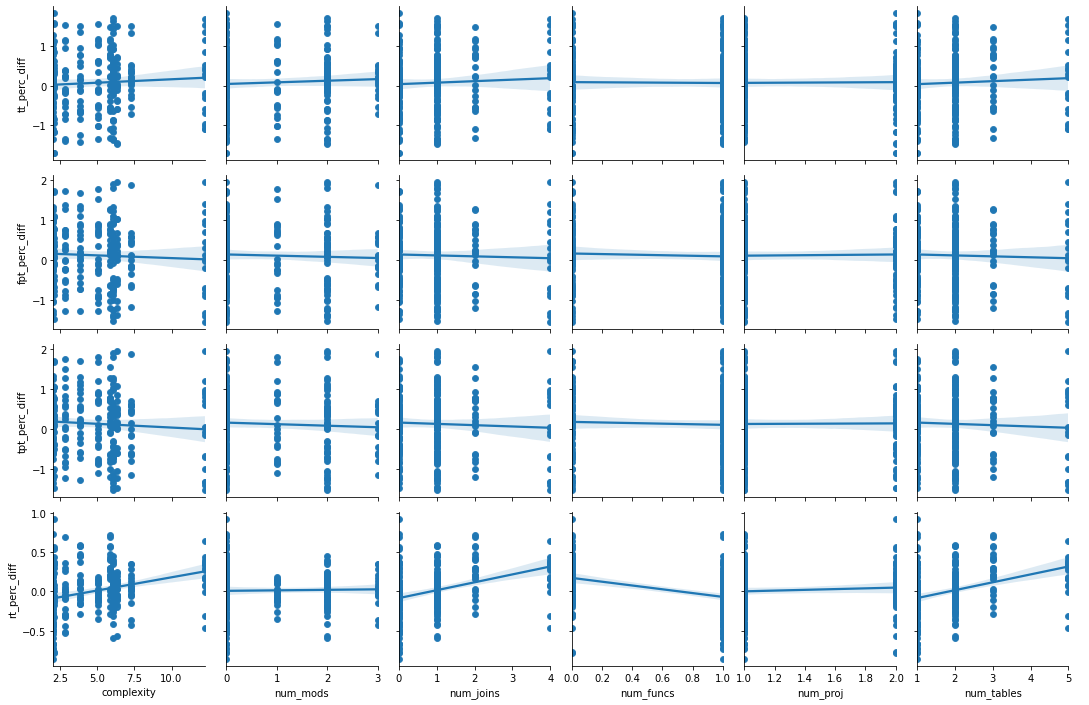

In [15]:
x_vars = ['complexity', 'num_mods', 'num_joins', 'num_funcs', 'num_proj', 'num_tables']
y_vars = dep_vars

g = sns.PairGrid(
    correct_answers,
    x_vars = x_vars,
    y_vars = y_vars,
#     hue = 'speakql_first'
)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.map_offdiag(sns.regplot)
g.add_legend()

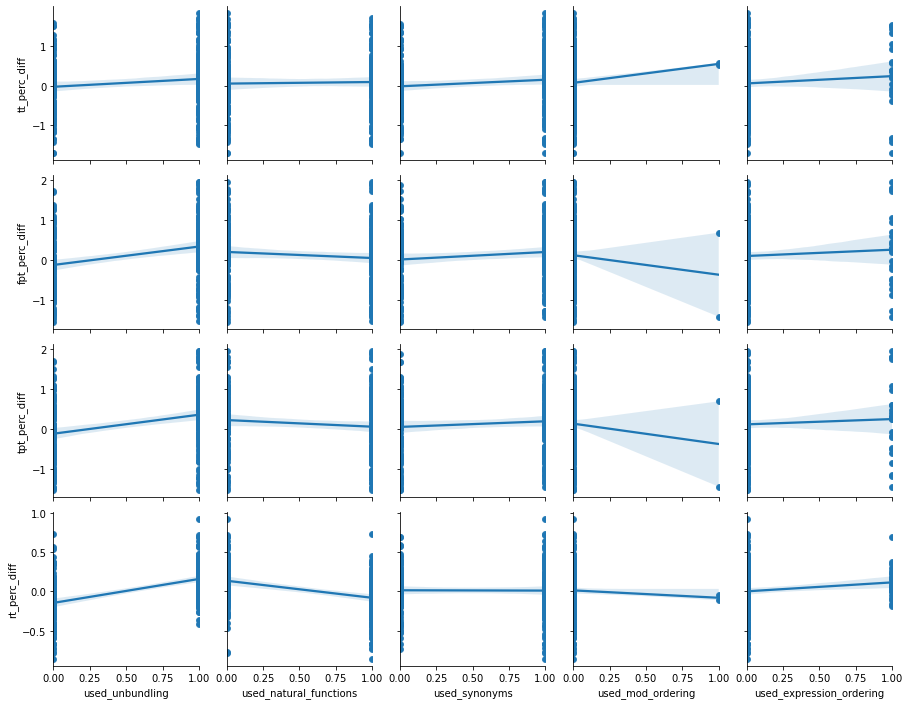

In [16]:
x_vars = ['used_unbundling', 'used_natural_functions', 'used_synonyms', 'used_mod_ordering', 'used_expression_ordering']
y_vars = dep_vars

g = sns.PairGrid(
    correct_answers,
    x_vars = x_vars,
    y_vars = y_vars,
#     hue = 'speakql_first'
)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.map_offdiag(sns.regplot)
g.add_legend()

### Query Attribute GLMs:

#### Colinearity tests

Complexity, complexity attributes, and query id / step is strongling colinear. Basically this is because complexity increases as the study progresses.

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_variables  = correct_answers[[
    'complexity', 'num_tables', 'step_abs', 'second_half', 'used_unbundling', 'used_synonyms', 
    'used_mod_ordering', 'used_expression_ordering', 
    'speakql_first'
]]
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,complexity,177.616962
1,num_tables,61.787360
2,step_abs,64.956069
3,second_half,6.291152
4,used_unbundling,3.805518
5,used_synonyms,2.066743
6,used_mod_ordering,1.046811
7,used_expression_ordering,1.194845
8,speakql_first,2.351076


In [18]:
import statsmodels.api as sm

# I initially thought this was interesting, but total time (last attempt) is not a good measure because we 
# see a decrease in total time due to not accounting for planning time of the first attempt which is the longest
# on average.

for column in dep_vars:
    x = correct_answers[[
        'num_tables',
        'num_funcs',
        'num_proj'
    ]]
    x = sm.add_constant(x)
    y = (correct_answers[column])
    model = sm.GLM(y, x).fit()
    predictions = model.predict(x)
    print_model = model.summary()
    print(print_model)

                 Generalized Linear Model Regression Results                  
Dep. Variable:           tt_perc_diff   No. Observations:                  250
Model:                            GLM   Df Residuals:                      246
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.59787
Method:                          IRLS   Log-Likelihood:                -288.42
Date:                Wed, 11 Jan 2023   Deviance:                       147.08
Time:                        09:56:15   Pearson chi2:                     147.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0887      0.243     -0.365      0.7

### Feature Usage GLMs

In [ ]:
correct_answers.columns

In [19]:
ca_mod = correct_answers
ca_mod['usedXpossible_unbundling'] = ca_mod.used_unbundling * ca_mod.unbundling_possible

In [20]:
for column in dep_vars:
    x = ca_mod[[
        'used_natural_functions',
        'used_synonyms',
        'used_expression_ordering',
        'used_mod_ordering',
        'used_unbundling',
        'step_abs'
    ]]
    x = sm.add_constant(x)
    y = (ca_mod[column])
    model = sm.GLM(y, x).fit()
    predictions = model.predict(x)
    print_model = model.summary()
    print(print_model)

                 Generalized Linear Model Regression Results                  
Dep. Variable:           tt_perc_diff   No. Observations:                  250
Model:                            GLM   Df Residuals:                      243
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                         0.58118
Method:                          IRLS   Log-Likelihood:                -283.35
Date:                Wed, 11 Jan 2023   Deviance:                       141.23
Time:                        09:56:38   Pearson chi2:                     141.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### **Findings from analysis above:**

**Recording time:**
Running a generalized linear model using recording time as dependent variable and query attributes (number of functions, number of tables, number of projections) as independent variables reveals that speakql recording time increased by .06 (6 percent) for every table in the function (p = 0.005), and decreased by .17 (17 percent) (p = 0.001) for every function in the query.

**Number of attempts until correct:**
On average, speakql queries required .43 (43 percent) more attempts than SQL queries (p = 0.016). However, the percent difference decreases by .24 (24 percent) for queries with at least one function (p = 0.005) and .07 (7 percent) per table referenced in the query (p = .07).

### View of perc differences by query
Let's take a look at if there are changes to perc difference as the experiment progressed. We will view it in query order, which will allow us to see if differences between SpeakQL and SQL change as participants gain more familiarity with SpeakQL.

#### Planning Time by Query (used vs. not used features):

In [ ]:

sns.boxplot(
    x='step_abs', 
    y='fpt_perc_diff', 
    hue='used_unbundling', 
    data=correct_answers
)

In [ ]:
sns.lmplot(
    data=correct_answers,
    x='step_abs',
    y='fpt_perc_diff'
)

#### Comparison of queries where unbundling was used vs. SQL

In [ ]:
correct_answers.columns

In [ ]:
correct_answers_ub = correct_answers.where(correct_answers.used_unbundling == 1).dropna(how = 'all')
correct_answers.shape
sns.boxplot(
    x='step_abs', 
    y='fpt_perc_diff',
    data=correct_answers_ub
)